In [1]:
import pandas as pd
from scipy import stats
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestRegressor 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score,recall_score,precision_score, confusion_matrix
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
import tensorflow
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn import linear_model 
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [2]:
df = pd.read_csv("./house.csv")

In [3]:
pd.set_option("display.max.columns", None)

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 22 columns):
id               21613 non-null int64
date             21613 non-null object
price            21613 non-null float64
price_bin        21613 non-null int64
bedrooms         21613 non-null int64
bathrooms        21613 non-null float64
sqft_living      21613 non-null int64
sqft_lot         21613 non-null int64
floors           21613 non-null float64
waterfront       21613 non-null int64
view             21613 non-null int64
condition        21613 non-null int64
grade            21613 non-null int64
sqft_above       21613 non-null int64
sqft_basement    21613 non-null int64
yr_built         21613 non-null int64
yr_renovated     21613 non-null int64
zipcode          21613 non-null int64
lat              21613 non-null float64
long             21613 non-null float64
sqft_living15    21613 non-null int64
sqft_lot15       21613 non-null int64
dtypes: float64(5), int64(16), object(1)
mem

,id,date,price,price_bin,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


Z powyższego rezultatu widzimy, że w naszym zbiorze nie ma brakujących wartości. Ewentualnie mogłyby być one zaszyte w zmiennych kategorycznych, lecz takich w naszym zbiorze nie ma. Dodatkowo mamy kolumnę date, która jest aktualnie obiektem więc zmienimy jej typ na "datetime". Dorobimy również zmienną "month", która posłuży nam do stworzenia zmiennej "quarter" czyli kwartał oraz "season" czyli pora roku (w naszym przypadku uproszczona do pełnych miesięcy). Ponadto wytniemy odrazu ze zbioru zmienne, których nie użyjemy w analizie czyli - "yr_renovated", "zipcode", "lat", "long", "sqft_living15", "sqft_lot15". Odrobine niejasne wydaje się, że dla zmiennej "bathrooms" mamy nie zawsze wartości dyskretne. Jakoże takich sytuacji jest dużo, to pozostawimy tą zmienną taką jaka jest, gdyż mogło chodzić o np. ubikację.

In [4]:
df = df.iloc[:, :16]
df.columns

Index(['id', 'date', 'price', 'price_bin', 'bedrooms', 'bathrooms',
       'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition',
       'grade', 'sqft_above', 'sqft_basement', 'yr_built'],
      dtype='object')

In [5]:
df['month_sold']   = df['date'].str[4:6].apply(int)
df['year_sold']    = df['date'].str[0:4].apply(int)
df['quarter'] = (((df.month_sold - 1) // 3) + 1).apply(str)
df['season']  = ((df.month_sold % 12 + 3) // 3).apply(str)
df['date']    = pd.to_datetime(df['date'])

print(df['date'].dtype) 
df.head()

datetime64[ns]


,id,date,price,price_bin,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,month_sold,year_sold,quarter,season
0,7129300520,2014-10-13,221900.0,0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,10,2014,4,4
1,6414100192,2014-12-09,538000.0,0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,12,2014,4,1
2,5631500400,2015-02-25,180000.0,0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,2,2015,1,1
3,2487200875,2014-12-09,604000.0,0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,12,2014,4,1
4,1954400510,2015-02-18,510000.0,0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,2,2015,1,1


In [6]:
(df.sqft_basement > 0).value_counts()

False    13126
True      8487
Name: sqft_basement, dtype: int64

Jako iż widać, że zmienna "sqft_basement" przyjmuje w większości przypadków wartość równą 0, to sugeruję stworzenie z niej zmiennej binarnej która będzie nam mówiła o tym, czy mieszkanie posiada piwnicę bądź też nie.

In [7]:
df['if_basement'] = (df.sqft_basement > 0)

Zmienna "yr_built" jako zmienna numeryczna nie będzie użyteczna w naszej predykcji. Możemy ją albo potraktować jako zmienną kategoryczną, bądź stworzyć przy jej użyciu inną zmienną, która określać nam będzie wiek nieruchomości w momencie sprzedaży (age). My stworzymy zmienną numeryczną oznaczającą wiek nieruchomości podczas sprzedaży.

In [8]:
df['age_sold'] = df['year_sold'] - df['yr_built']

In [9]:
df.iloc[:,0:].describe()

,id,price,price_bin,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,month_sold,year_sold,age_sold
count,2.161300e+04,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,4.580302e+09,5.401822e+05,0.067783,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,1971.005136,6.574423,2014.322954,43.317818
std,2.876566e+09,3.673622e+05,0.251379,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,29.373411,3.115308,0.467616,29.375493
min,1.000102e+06,7.500000e+04,0.000000,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,1.000000,2014.000000,-1.000000
25%,2.123049e+09,3.219500e+05,0.000000,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,4.000000,2014.000000,18.000000
50%,3.904930e+09,4.500000e+05,0.000000,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,6.000000,2014.000000,40.000000
75%,7.308900e+09,6.450000e+05,0.000000,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,9.000000,2015.000000,63.000000
max,9.900000e+09,7.700000e+06,1.000000,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,12.000000,2015.000000,115.000000


Z powyższych statystyk możemy zauważyć, że w zbiorze nie występują wartości, które odstawałyby znacząco od innych. Sprawdźmy jeszcze, czy w naszych danych są zachowane logiczne reguły (np. powierzchnia użytkowa nie może być mniejsza niż powierzchnia poddasza czy piwnicy)

In [10]:
df[df.sqft_living < df.sqft_above]
df[df.sqft_living < df.sqft_above]

,id,date,price,price_bin,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,month_sold,year_sold,quarter,season,if_basement,age_sold


Zmienne, które mogą być podejrzane jako outliery to:
"bedrooms" (ponieważ 33 wydaje się podejrzaną liczbą sypialni w jednym domu),
"sqft_living",
"sqft_lot",
"sqft_above",
"sqft_basement"

In [11]:
z = np.abs(stats.zscore(df[["bedrooms", "sqft_living", "sqft_lot", "sqft_above", "sqft_basement"]]))

df = df[(z < 3).all(axis=1)]
df.shape

(20728, 22)

Zastosowaliśmy metodę usuwania wartości odstających Z-Score. Zbiór danych nieznacznie się w tym wypadku pomniejszył.

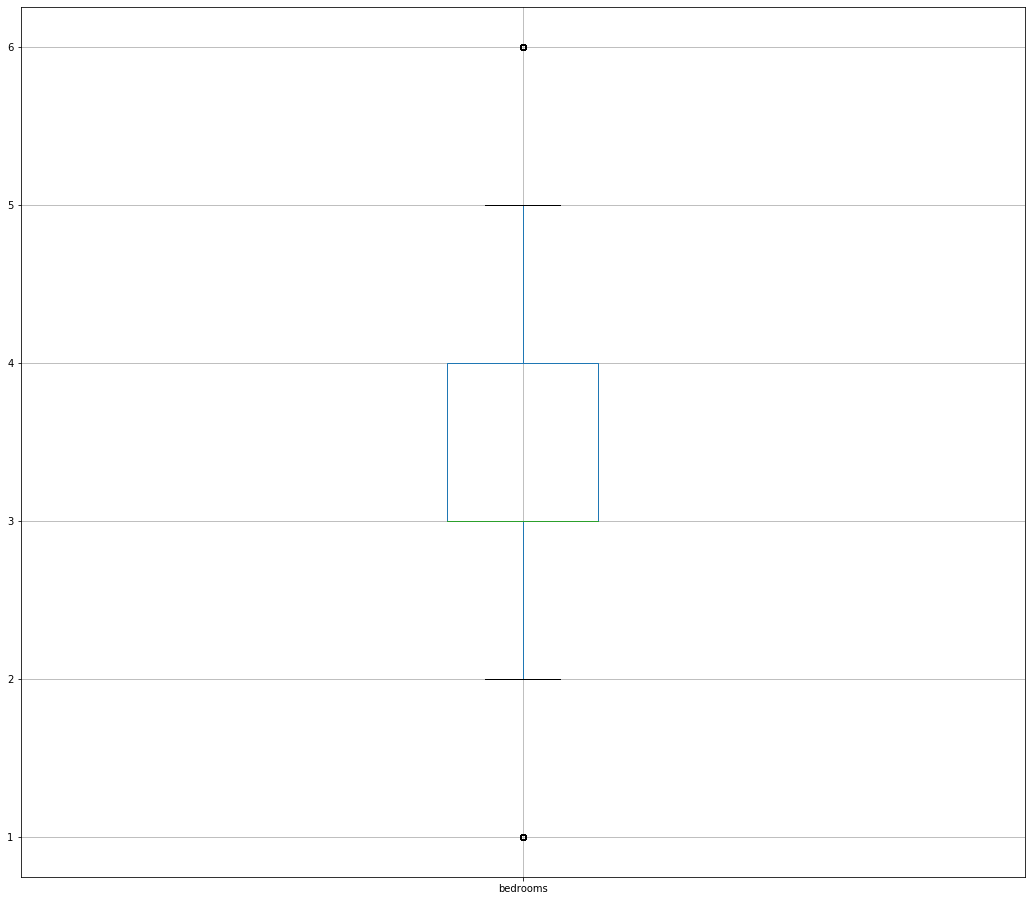

In [12]:
plt.figure(figsize=(18, 16))
df.boxplot("bedrooms")

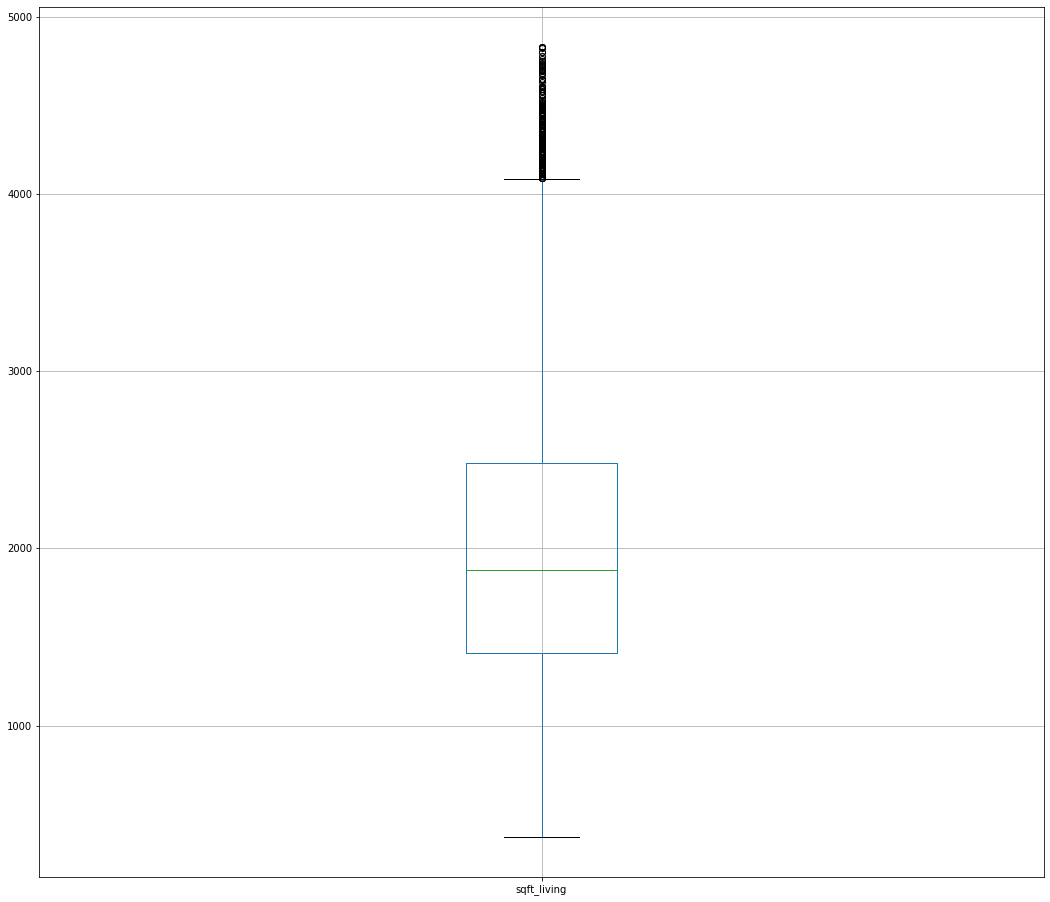

In [13]:
plt.figure(figsize=(18, 16))
df.boxplot("sqft_living")

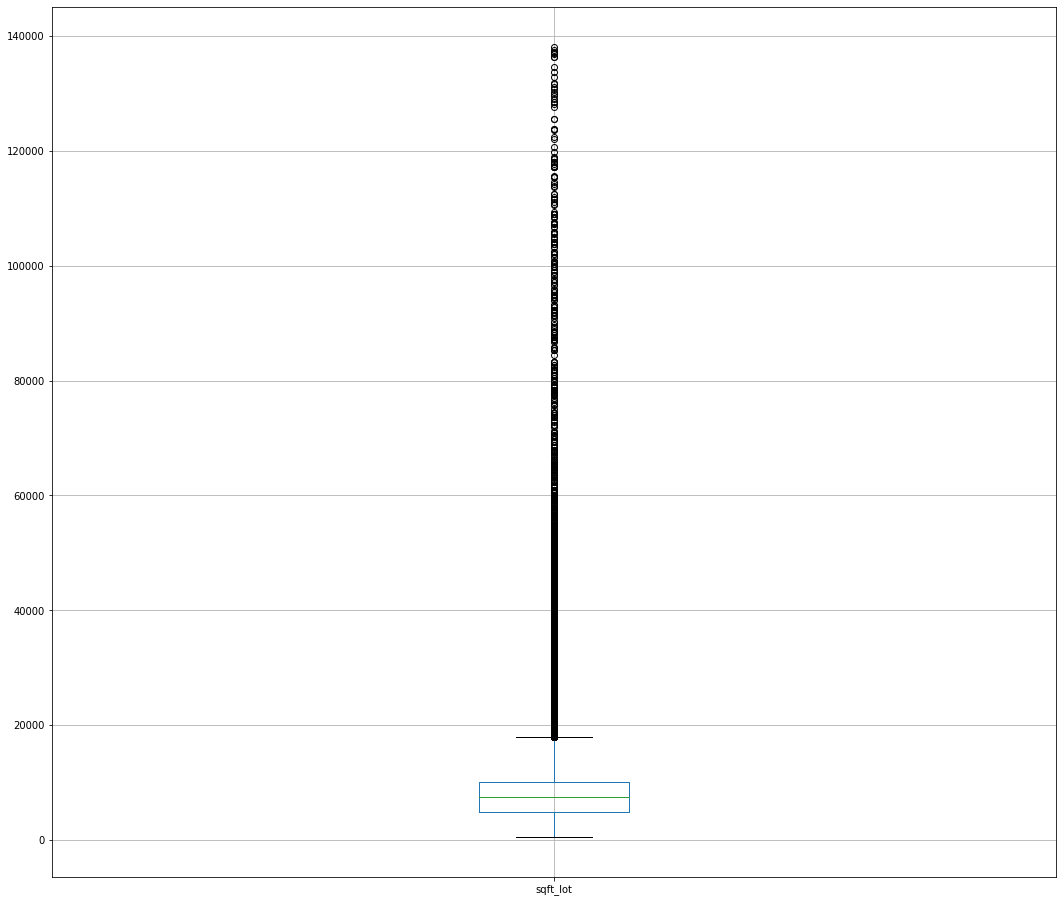

In [14]:
plt.figure(figsize=(18, 16))
df.boxplot("sqft_lot")

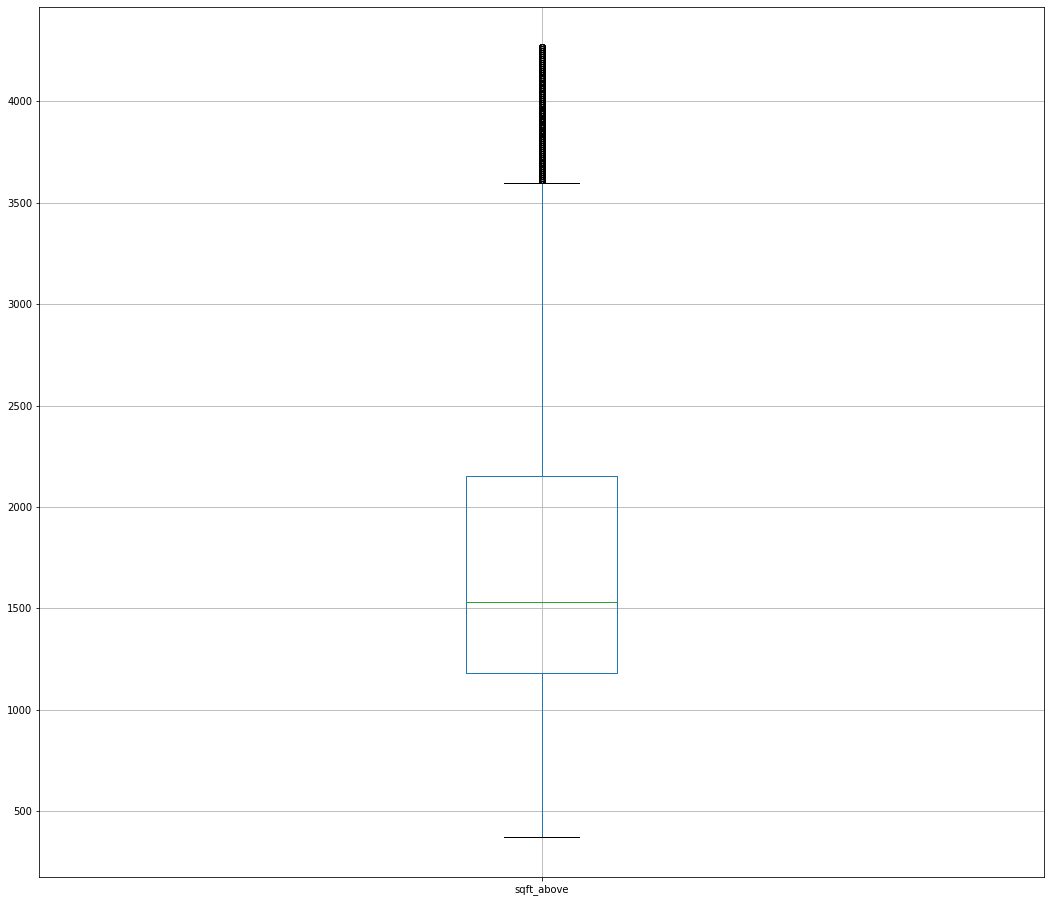

In [15]:
plt.figure(figsize=(18, 16))
df.boxplot("sqft_above")

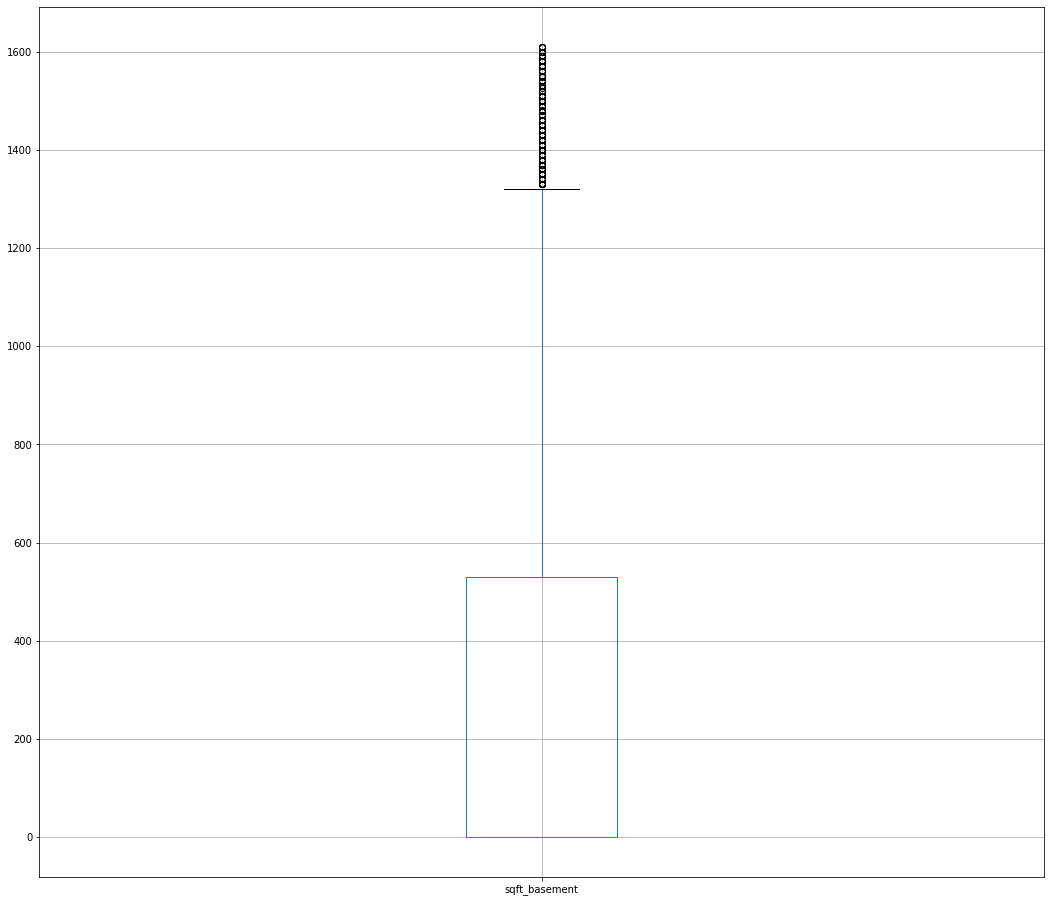

In [16]:
plt.figure(figsize=(18, 16))
df.boxplot("sqft_basement")

Widać, że kształty wykresów pudełkowych po usunięciu wartości odstających przy użyciu Z-score są dopuszczalne. Widać wiele wartości poza "pudełkiem", lecz widać iż zdażają się one w dużej ilości.

In [17]:
df.loc[df["age_sold"] == -1 , :]

,id,date,price,price_bin,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,month_sold,year_sold,quarter,season,if_basement,age_sold
1763,1832100030,2014-06-25,597326.0,0,4,4.00,3570,8250,2.0,0,0,3,10,2860,710,2015,6,2014,2,3,True,-1
2687,3076500830,2014-10-29,385195.0,0,1,1.00,710,6000,1.5,0,0,3,6,710,0,2015,10,2014,4,4,False,-1
7526,9520900210,2014-12-31,614285.0,0,5,2.75,2730,6401,2.0,0,0,3,8,2730,0,2015,12,2014,4,1,False,-1
8039,1250200495,2014-06-24,455000.0,0,2,1.50,1200,1259,2.0,0,0,3,8,1000,200,2015,6,2014,2,3,True,-1
14489,2770601530,2014-08-26,500000.0,0,2,2.25,1570,1269,2.0,0,0,3,9,1280,290,2015,8,2014,3,3,True,-1
17098,9126100346,2014-06-17,350000.0,0,3,2.00,1380,3600,3.0,0,0,3,8,1380,0,2015,6,2014,2,3,False,-1
19805,9126100765,2014-08-01,455000.0,0,3,1.75,1320,1014,3.0,0,0,3,9,1320,0,2015,8,2014,3,3,False,-1
20770,9310300160,2014-08-28,357000.0,0,5,2.50,2990,9240,2.0,0,0,3,8,2990,0,2015,8,2014,3,3,False,-1
20852,1257201420,2014-07-09,595000.0,0,4,3.25,3730,4560,2.0,0,0,3,9,2760,970,2015,7,2014,3,3,True,-1
20963,6058600220,2014-07-31,230000.0,0,3,1.50,1040,1264,2.0,0,0,3,9,900,140,2015,7,2014,3,3,True,-1


W naszym zbiorze wystąpiły przypadki, w których zmienna "age_sold" osiągnęła wartość -1. Jest to dopuszczalna wartość, gdyż mogło się zdażyć iż zakupiona nieruchomość był sprzedana jeszcze przed wybudowaniem. 

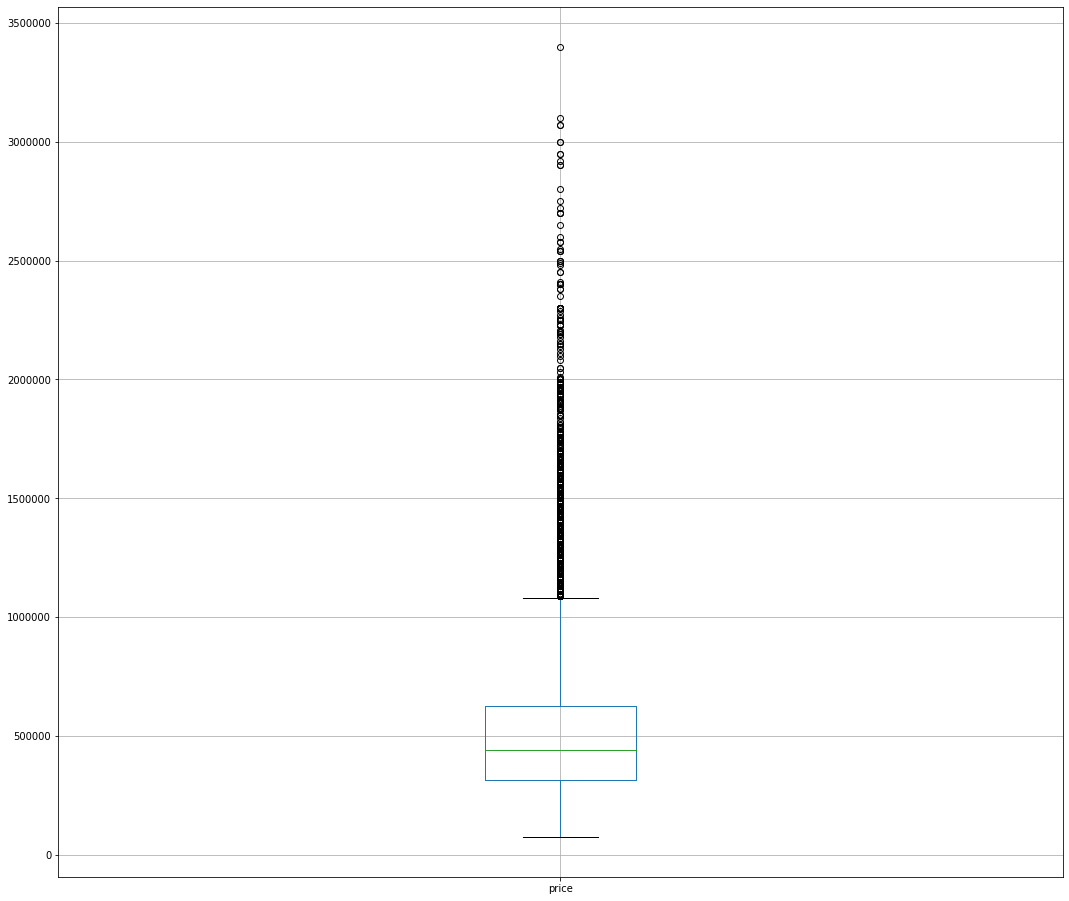

In [18]:
plt.figure(figsize=(18, 16))
df.boxplot(column = "price")

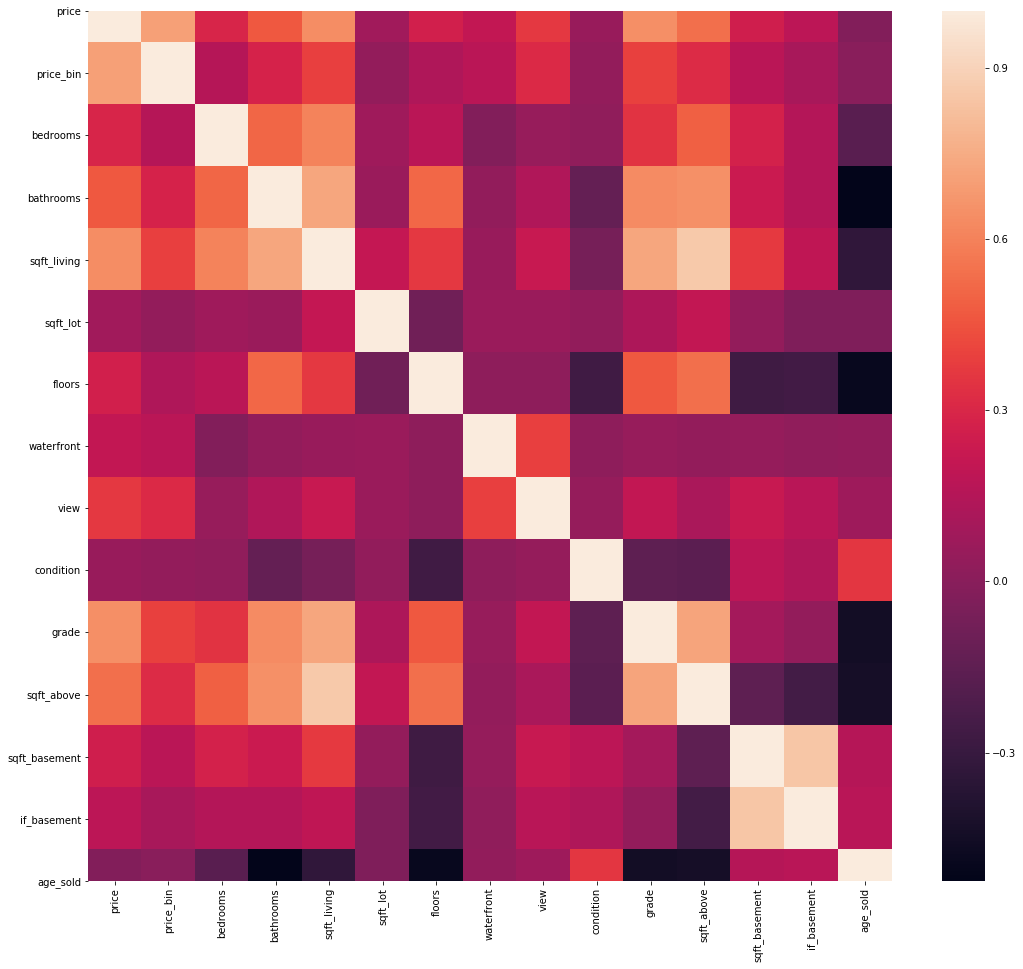

In [19]:
plt.figure(figsize=(18, 16))
plot_variables = list(df.columns[2:])
for var in ["yr_built", "month_sold", "year_sold"]:
    plot_variables.remove(var)

sns.heatmap(data= df.loc[:, plot_variables].corr())

In [20]:
df.loc[:, plot_variables].corr()

,price,price_bin,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,if_basement,age_sold
price,1.000000,0.705297,0.293228,0.467008,0.640445,0.088202,0.266445,0.204320,0.364861,0.053946,0.645421,0.540739,0.258923,0.180800,-0.024179
price_bin,0.705297,1.000000,0.156720,0.279327,0.389969,0.037648,0.135207,0.175121,0.310004,0.037672,0.393130,0.319898,0.174764,0.111856,0.001242
bedrooms,0.293228,0.156720,1.000000,0.507278,0.604253,0.077277,0.176489,-0.023203,0.051207,0.023884,0.347886,0.491483,0.278461,0.148893,-0.168995
bathrooms,0.467008,0.279327,0.507278,1.000000,0.728966,0.059629,0.514905,0.030819,0.138129,-0.129026,0.632690,0.650077,0.231487,0.152647,-0.525140
sqft_living,0.640445,0.389969,0.604253,0.728966,1.000000,0.211983,0.367049,0.054809,0.219693,-0.061089,0.731334,0.861504,0.372880,0.195636,-0.331843
sqft_lot,0.088202,0.037648,0.077277,0.059629,0.211983,1.000000,-0.087974,0.060250,0.063771,0.031211,0.127852,0.206749,0.034957,-0.032407,-0.032603
floors,0.266445,0.135207,0.176489,0.514905,0.367049,-0.087974,1.000000,0.017335,0.019462,-0.265984,0.466187,0.540800,-0.273549,-0.262049,-0.494896
waterfront,0.204320,0.175121,-0.023203,0.030819,0.054809,0.060250,0.017335,1.000000,0.392144,0.020135,0.050143,0.035101,0.042581,0.025637,0.034175
view,0.364861,0.310004,0.051207,0.138129,0.219693,0.063771,0.019462,0.392144,1.000000,0.043762,0.204782,0.112422,0.222348,0.168371,0.073530
condition,0.053946,0.037672,0.023884,-0.129026,-0.061089,0.031211,-0.265984,0.020135,0.043762,1.000000,-0.150921,-0.165339,0.183191,0.132671,0.359075


Niepokojąca jest siła relacji między zmiennymi "sqft_above" oraz "sqft_living". Zbadajmy ją dokładniej.

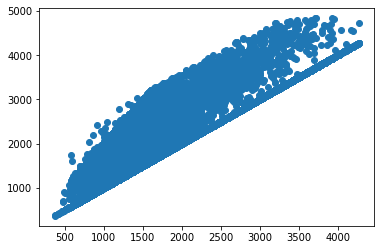

In [21]:
plt.scatter(df.sqft_above, df.sqft_living)

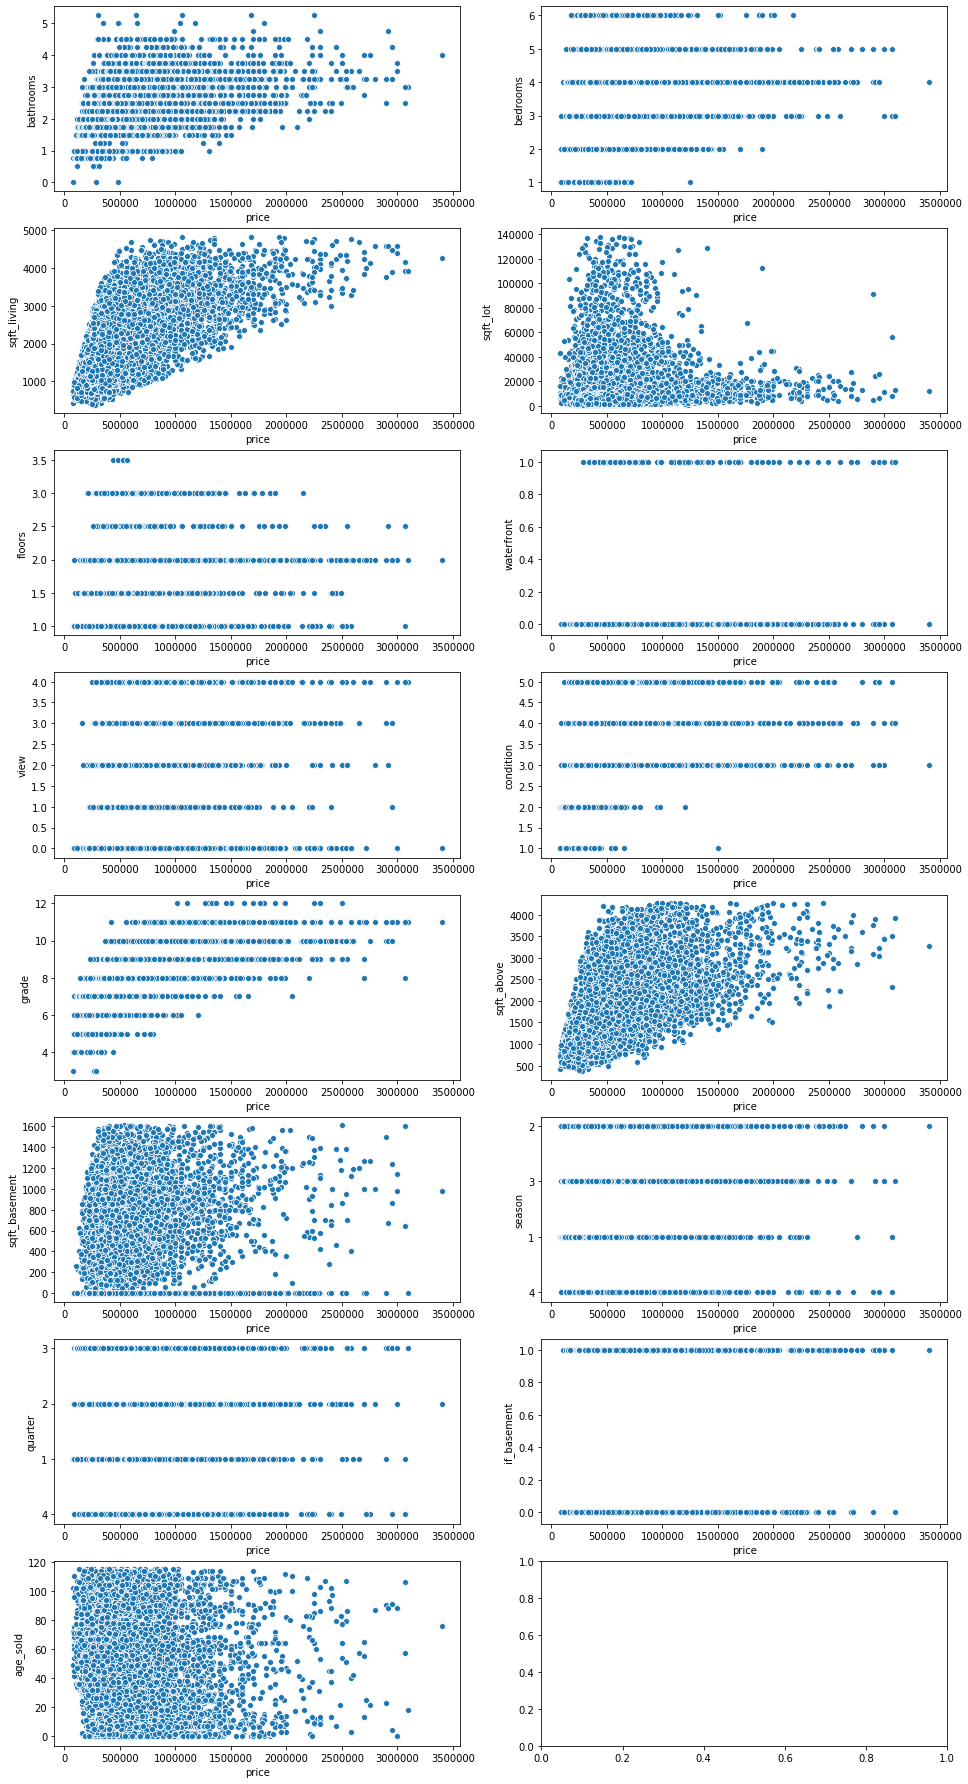

In [22]:
fig, ax = plt.subplots(8, 2, figsize=(16,32))
sns.scatterplot(df.price, df.bathrooms, ax=ax[0,0]) 
sns.scatterplot(df.price, df.bedrooms, ax=ax[0,1]) 
sns.scatterplot(df.price, df.sqft_living, ax=ax[1,0]) 
sns.scatterplot(df.price, df.sqft_lot, ax=ax[1,1])
sns.scatterplot(df.price, df.floors, ax=ax[2,0])
sns.scatterplot(df.price, df.waterfront, ax=ax[2,1])
sns.scatterplot(df.price, df.view, ax=ax[3,0])
sns.scatterplot(df.price, df.condition, ax=ax[3,1])
sns.scatterplot(df.price, df.grade, ax=ax[4,0])
sns.scatterplot(df.price, df.sqft_above, ax=ax[4,1])
sns.scatterplot(df.price, df.sqft_basement, ax=ax[5,0])
sns.scatterplot(df.price, df.season, ax=ax[5,1])
sns.scatterplot(df.price, df.quarter, ax=ax[6,0])
sns.scatterplot(df.price, df.if_basement, ax=ax[6,1])
sns.scatterplot(df.price, df.age_sold, ax=ax[7,0])

Odrzucamy zmienną "sqft_above", która jest silnie skorelowana ze zmienną "sqft_living", a "sqft_living" jest silniej skorelowana ze zmienną objaśnianą. Skorzystamy jeszcze z innych metod doboru zmiennych objaśniających ze względu na fakt, iż występują u nas również zmienne kategoryczne.

In [25]:
print(df.groupby("season")["price"].mean())
print(df.groupby("quarter")["price"].mean())

season
1    492163.197740
2    525060.685650
3    520471.519619
4    501688.536938
Name: price, dtype: float64
quarter
1    506056.437183
2    527114.438312
3    511004.457053
4    499531.899032
Name: price, dtype: float64


Musimy usunąc z naszych zmiennych objaśnianych jedną z dwóch powyższych zmiennych, gdyż zachodzą one na siebie. Po zbadaniu, w której zmiennej są większe różnice średnich cen nieruchomości wewnątrz grup stworzonych z ich wartości stwierdzam, że lepiej będzie zostawić zmienną "quarter".

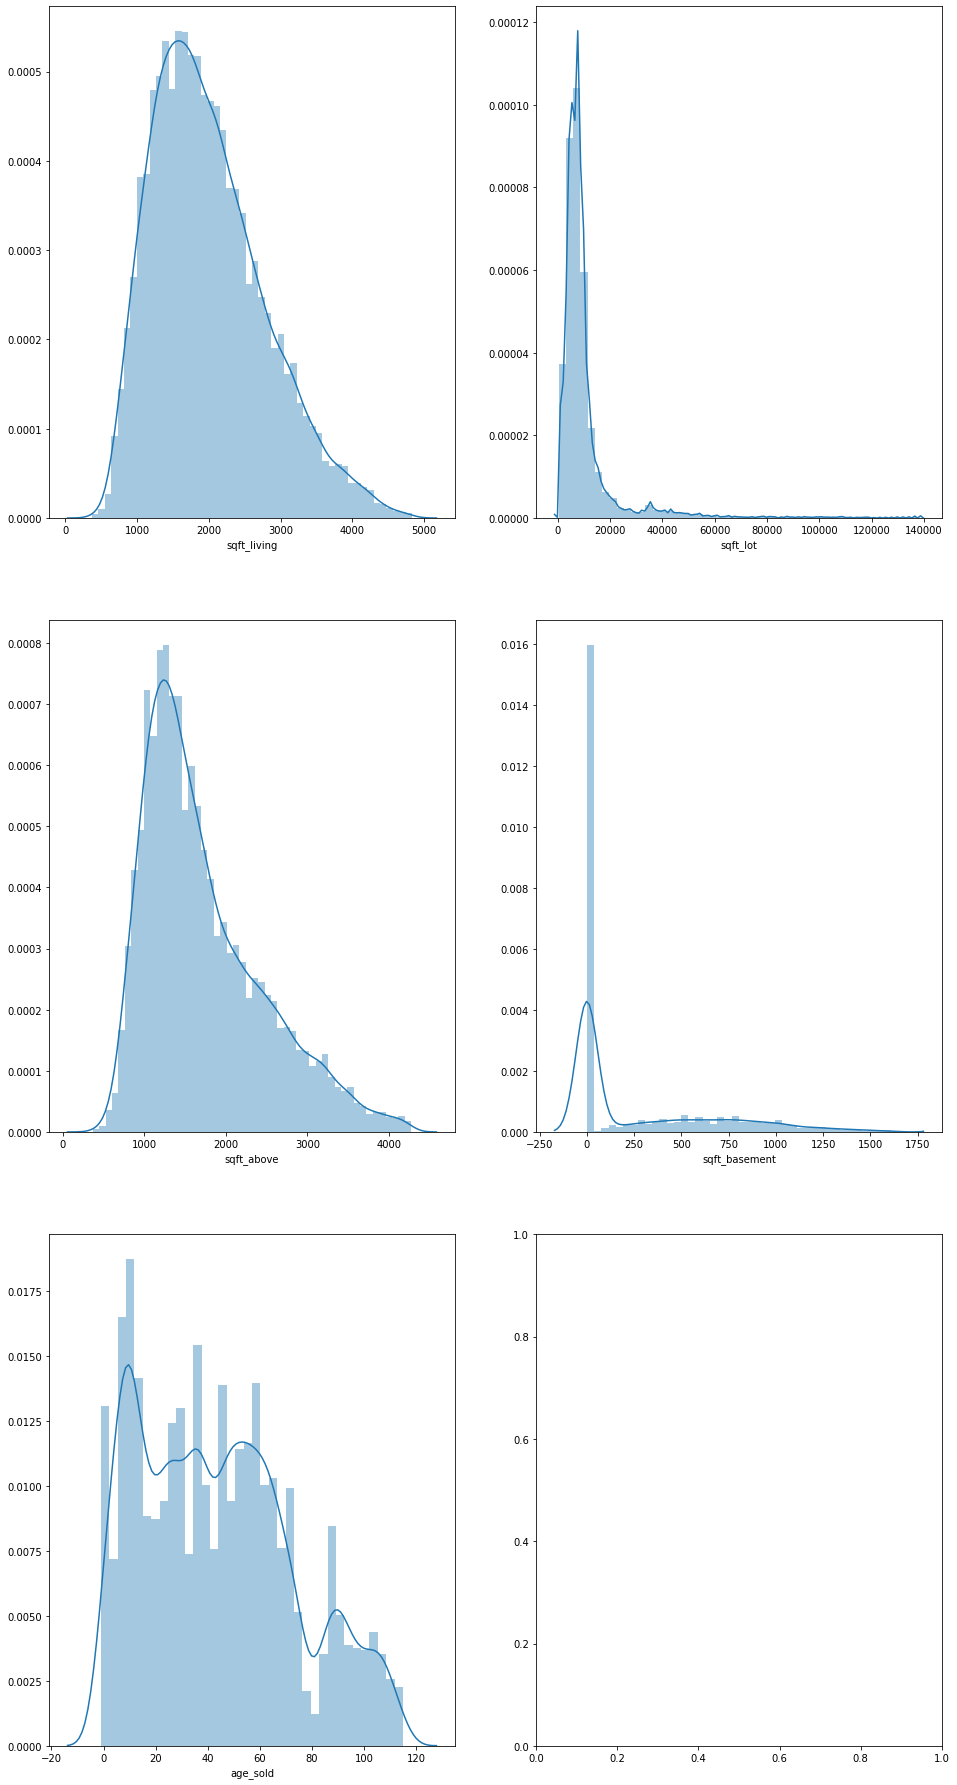

In [26]:
fig, ax = plt.subplots(3, 2, figsize=(16,32))
sns.distplot(df.sqft_living, ax=ax[0,0]) 
sns.distplot(df.sqft_lot, ax=ax[0,1])
sns.distplot(df.sqft_above, ax=ax[1,0])
sns.distplot(df.sqft_basement, ax=ax[1,1])
sns.distplot(df.age_sold, ax=ax[2,0])

Zmienne numeryczne nie zawszę mają rozkład normalny. Dlatego też zrezygnujemy ze standaryzacji i wykorzystamy tutaj normalizację min-max.

In [27]:
df = df.drop(columns = ["sqft_above", "season"])

x_df = df.iloc[:, 4:].drop(columns = ["yr_built", "month_sold", "year_sold"])
y_reg_df = df.iloc[:, 2]
y_class_df = df.iloc[:, 3]

In [28]:
x_df.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_basement,quarter,if_basement,age_sold
0,3,1.00,1180,5650,1.0,0,0,3,7,0,4,False,59
1,3,2.25,2570,7242,2.0,0,0,3,7,400,4,True,63
2,2,1.00,770,10000,1.0,0,0,3,6,0,1,False,82
3,4,3.00,1960,5000,1.0,0,0,5,7,910,4,True,49
4,3,2.00,1680,8080,1.0,0,0,3,8,0,1,False,28


Podzieliliśmy zbiór na zmienne objaśniane i zmienne objaśniające.

In [29]:
df['price_bin'].value_counts()

0    19656
1     1072
Name: price_bin, dtype: int64

Widzimy sporą nadreprezentację mieszkań kosztujących poniżej 1 000 000, dlatego najlepszą miarą ewaluacji naszego modelu klasyfikującego nie będzie accuracy.

I. KLASYFIKACJA

In [30]:
X_train, X_test, y_train, y_test = train_test_split(x_df, y_class_df, test_size = 0.2)

scale_vars = ['bedrooms', 'bathrooms','sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition','grade', 'sqft_basement', 'age_sold']

for var in scale_vars:
    min_ = X_train.loc[:, var].min()
    max_ = X_train.loc[:, var].max()
    X_train[[var]] = (X_train[[var]] - min_)/(max_ - min_)
    X_test[[var]]  = (X_test[[var]] - min_)/(max_ - min_)
    
X_train.head()

C:\Users\Y50\Anaconda3\lib\site-packages\pandas\core\frame.py:3494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_basement,quarter,if_basement,age_sold
7583,0.6,0.333333,0.253363,0.080544,0.0,0.0,0.0,0.75,0.444444,0.310559,2,True,0.517241
5484,0.2,0.333333,0.289238,0.025297,0.0,0.0,0.0,0.50,0.444444,0.416149,3,True,0.646552
3960,0.2,0.285714,0.289238,0.025297,0.0,0.0,0.0,0.50,0.444444,0.409938,3,True,0.560345
7890,0.4,0.285714,0.224215,0.057791,0.0,0.0,0.0,0.75,0.444444,0.000000,2,False,0.465517
6525,0.2,0.190476,0.103139,0.032566,0.0,0.0,0.0,0.75,0.444444,0.000000,1,False,0.818966


In [31]:
print(y_test.value_counts())

0    3941
1     205
Name: price_bin, dtype: int64


1. Model regresji logistycznej

In [32]:
classifier = LogisticRegression()
classifier.fit(X_train, y_train)
prediction = classifier.predict(X_test)

acc = accuracy_score(y_test, prediction)
prec = precision_score(y_test, prediction)
rec = recall_score(y_test, prediction)
f1 = f1_score(y_test, prediction)

results = pd.DataFrame([['Logistic Regression (Every feature)', acc, prec, rec, f1]],columns=['Model', 'Accuracy', 'Precision', 'Recall','F1 Score'])
results

C:\Users\Y50\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression (Every feature),0.964303,0.766355,0.4,0.525641


Jako że mamy mniejszą reprezentację nieruchomości poniżej 1 000 000 to lepszą miarą porównania jakości modelu w tym przypadku będzie F1 Score (średnia z recall czyli ilość przewidzianych nieruchomości powyżej 1 000 000 przez wszystkich zakupionych po faktycznie cenie większej od 1 000 000 oraz precision czyli ilość przewidzianych nieruchomości powyżej 1 000 000 przez wszystkich zakwalifikowanych przez nas jako nie tańsze niż 1 000 000).

W przypadku modelu regresji logistycznej mamy do dyspozycji RFE, czyli rekurencyjne usuwanie zmiennych. Działa on w taki sposób, że na podstawie wyników modelu usuwamy kolejne zmienne. Posłużymy się tym algorytmem do przetestowania modelu na różnych kombinacjach zmiennych objaśniających.

In [33]:
for i in range(6, 13):
    rfe = RFE(classifier, n_features_to_select = i)
    rfe = rfe.fit(X_train, y_train)

    classifier.fit(X_train[X_train.columns[rfe.support_]], y_train)

    prediction = classifier.predict(X_test[X_train.columns[rfe.support_]])
    acc = accuracy_score(y_test, prediction)
    prec = precision_score(y_test, prediction)
    rec = recall_score(y_test, prediction)
    f1 = f1_score(y_test, prediction)

    model_results = pd.DataFrame([['Logistic Regression with RFE (' + str(i) + ' features)', acc, prec, rec, f1]],
                                 columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

    results = results.append(model_results, ignore_index = True)
results

C:\Users\Y50\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Y50\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Y50\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Y50\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Y50\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warnin

,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression (Every feature),0.964303,0.766355,0.400000,0.525641
1,Logistic Regression with RFE (6 features),0.963097,0.776596,0.356098,0.488294
2,Logistic Regression with RFE (7 features),0.964303,0.776699,0.390244,0.519481
3,Logistic Regression with RFE (8 features),0.964785,0.786408,0.395122,0.525974
4,Logistic Regression with RFE (9 features),0.964544,0.778846,0.395122,0.524272
5,Logistic Regression with RFE (10 features),0.964544,0.778846,0.395122,0.524272
6,Logistic Regression with RFE (11 features),0.963821,0.761905,0.390244,0.516129
7,Logistic Regression with RFE (12 features),0.964303,0.766355,0.400000,0.525641


2. Naiwny model Bayes'owski

In [34]:
classifier = GaussianNB()
classifier.fit(X_train, y_train)
prediction = classifier.predict(X_test)

acc = accuracy_score(y_test, prediction)
prec = precision_score(y_test, prediction)
rec = recall_score(y_test, prediction)
f1 = f1_score(y_test, prediction)

model_results = pd.DataFrame([['Naive Bayes (Every feature)', acc, prec, rec, f1]],columns=['Model', 'Accuracy', 'Precision', 'Recall','F1 Score'])
results = results.append(model_results, ignore_index = True)
results

,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression (Every feature),0.964303,0.766355,0.400000,0.525641
1,Logistic Regression with RFE (6 features),0.963097,0.776596,0.356098,0.488294
2,Logistic Regression with RFE (7 features),0.964303,0.776699,0.390244,0.519481
3,Logistic Regression with RFE (8 features),0.964785,0.786408,0.395122,0.525974
4,Logistic Regression with RFE (9 features),0.964544,0.778846,0.395122,0.524272
5,Logistic Regression with RFE (10 features),0.964544,0.778846,0.395122,0.524272
6,Logistic Regression with RFE (11 features),0.963821,0.761905,0.390244,0.516129
7,Logistic Regression with RFE (12 features),0.964303,0.766355,0.400000,0.525641
8,Naive Bayes (Every feature),0.932947,0.396011,0.678049,0.500000


Jakoże wcześniej użyta metoda była odpowiednia dla regresji logistycznej, tak teraz przy algorytmie Bayesowskim jesteśmy zmuszeni skorzystać z innego sposobu doboru feature'sów. Skorzystamy teraz z jednej z filter methodes w wybieraniu atrybutów. Tym razem wykorzystywana przez nas metoda nie bierze pod uwagę wyników modelu, lecz dzieli zbiór przed modelowaniem. 

In [35]:
for i in range(5, 13):
    top_k_vars = SelectKBest(score_func=f_classif, k=i)
    X_train_new = top_k_vars.fit_transform(X_train, y_train)
    columns_new = [X_train.columns[i] for i in top_k_vars.get_support(indices=True)]
    X_test_new = X_test[columns_new]
    classifier = GaussianNB()
    classifier.fit(X_train_new, y_train)
    
    prediction = classifier.predict(X_test_new)
    acc = accuracy_score(y_test, prediction)
    prec = precision_score(y_test, prediction)
    rec = recall_score(y_test, prediction)
    f1 = f1_score(y_test, prediction)

    model_results = pd.DataFrame([['Naive Bayes (' + str(i) + ' features)', acc, prec, rec, f1]],columns=['Model', 'Accuracy', 'Precision', 'Recall','F1 Score'])
    results = results.append(model_results, ignore_index = True)
    
results

,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression (Every feature),0.964303,0.766355,0.400000,0.525641
1,Logistic Regression with RFE (6 features),0.963097,0.776596,0.356098,0.488294
2,Logistic Regression with RFE (7 features),0.964303,0.776699,0.390244,0.519481
3,Logistic Regression with RFE (8 features),0.964785,0.786408,0.395122,0.525974
4,Logistic Regression with RFE (9 features),0.964544,0.778846,0.395122,0.524272
5,Logistic Regression with RFE (10 features),0.964544,0.778846,0.395122,0.524272
6,Logistic Regression with RFE (11 features),0.963821,0.761905,0.390244,0.516129
7,Logistic Regression with RFE (12 features),0.964303,0.766355,0.400000,0.525641
8,Naive Bayes (Every feature),0.932947,0.396011,0.678049,0.500000
9,Naive Bayes (5 features),0.935118,0.398089,0.609756,0.481696


W przypadku algorytmu naiwnego Bayesa, model puszczony na 6 zmiennych okazał się najbardziej trafiającym w nasze oczekiwania.

3a. K-najbliższych sąsiadów dla k = 3

In [36]:
classifier = KNeighborsClassifier(n_neighbors=3)
classifier.fit(X_train, y_train)
prediction = classifier.predict(X_test)

acc = accuracy_score(y_test, prediction)
prec = precision_score(y_test, prediction)
rec = recall_score(y_test, prediction)
f1 = f1_score(y_test, prediction)

model_results = pd.DataFrame([['K-nearest neighbors for k=3 (Every feature)', acc, prec, rec, f1]],columns=['Model', 'Accuracy', 'Precision', 'Recall','F1 Score'])
results = results.append(model_results, ignore_index = True)
results

,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression (Every feature),0.964303,0.766355,0.400000,0.525641
1,Logistic Regression with RFE (6 features),0.963097,0.776596,0.356098,0.488294
2,Logistic Regression with RFE (7 features),0.964303,0.776699,0.390244,0.519481
3,Logistic Regression with RFE (8 features),0.964785,0.786408,0.395122,0.525974
4,Logistic Regression with RFE (9 features),0.964544,0.778846,0.395122,0.524272
5,Logistic Regression with RFE (10 features),0.964544,0.778846,0.395122,0.524272
6,Logistic Regression with RFE (11 features),0.963821,0.761905,0.390244,0.516129
7,Logistic Regression with RFE (12 features),0.964303,0.766355,0.400000,0.525641
8,Naive Bayes (Every feature),0.932947,0.396011,0.678049,0.500000
9,Naive Bayes (5 features),0.935118,0.398089,0.609756,0.481696


In [37]:
for i in range(5, 13):
    top_k_vars = SelectKBest(score_func=f_classif, k=i)
    X_train_new = top_k_vars.fit_transform(X_train, y_train)
    columns_new = [X_train.columns[i] for i in top_k_vars.get_support(indices=True)]
    X_test_new = X_test[columns_new]
    classifier = KNeighborsClassifier(n_neighbors=3)
    classifier.fit(X_train_new, y_train)
    
    prediction = classifier.predict(X_test_new)
    acc = accuracy_score(y_test, prediction)
    prec = precision_score(y_test, prediction)
    rec = recall_score(y_test, prediction)
    f1 = f1_score(y_test, prediction)

    model_results = pd.DataFrame([['K-nearest neighbors for k=3 (' + str(i) + ' features)', acc, prec, rec, f1]],columns=['Model', 'Accuracy', 'Precision', 'Recall','F1 Score'])
    results = results.append(model_results, ignore_index = True)
    
results

,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression (Every feature),0.964303,0.766355,0.400000,0.525641
1,Logistic Regression with RFE (6 features),0.963097,0.776596,0.356098,0.488294
2,Logistic Regression with RFE (7 features),0.964303,0.776699,0.390244,0.519481
3,Logistic Regression with RFE (8 features),0.964785,0.786408,0.395122,0.525974
4,Logistic Regression with RFE (9 features),0.964544,0.778846,0.395122,0.524272
5,Logistic Regression with RFE (10 features),0.964544,0.778846,0.395122,0.524272
6,Logistic Regression with RFE (11 features),0.963821,0.761905,0.390244,0.516129
7,Logistic Regression with RFE (12 features),0.964303,0.766355,0.400000,0.525641
8,Naive Bayes (Every feature),0.932947,0.396011,0.678049,0.500000
9,Naive Bayes (5 features),0.935118,0.398089,0.609756,0.481696


3b. K-najbliższych sąsiadów dla k = 6

In [38]:
classifier = KNeighborsClassifier(n_neighbors=6)
classifier.fit(X_train, y_train)
prediction = classifier.predict(X_test)

acc = accuracy_score(y_test, prediction)
prec = precision_score(y_test, prediction)
rec = recall_score(y_test, prediction)
f1 = f1_score(y_test, prediction)

model_results = pd.DataFrame([['K-nearest neighbors for k=6 (Every feature)', acc, prec, rec, f1]],columns=['Model', 'Accuracy', 'Precision', 'Recall','F1 Score'])
results = results.append(model_results, ignore_index = True)
results

,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression (Every feature),0.964303,0.766355,0.400000,0.525641
1,Logistic Regression with RFE (6 features),0.963097,0.776596,0.356098,0.488294
2,Logistic Regression with RFE (7 features),0.964303,0.776699,0.390244,0.519481
3,Logistic Regression with RFE (8 features),0.964785,0.786408,0.395122,0.525974
4,Logistic Regression with RFE (9 features),0.964544,0.778846,0.395122,0.524272
5,Logistic Regression with RFE (10 features),0.964544,0.778846,0.395122,0.524272
6,Logistic Regression with RFE (11 features),0.963821,0.761905,0.390244,0.516129
7,Logistic Regression with RFE (12 features),0.964303,0.766355,0.400000,0.525641
8,Naive Bayes (Every feature),0.932947,0.396011,0.678049,0.500000
9,Naive Bayes (5 features),0.935118,0.398089,0.609756,0.481696


In [39]:
for i in range(5, 13):
    top_k_vars = SelectKBest(score_func=f_classif, k=i)
    X_train_new = top_k_vars.fit_transform(X_train, y_train)
    columns_new = [X_train.columns[i] for i in top_k_vars.get_support(indices=True)]
    X_test_new = X_test[columns_new]
    classifier = KNeighborsClassifier(n_neighbors=6)
    classifier.fit(X_train_new, y_train)
    
    prediction = classifier.predict(X_test_new)
    acc = accuracy_score(y_test, prediction)
    prec = precision_score(y_test, prediction)
    rec = recall_score(y_test, prediction)
    f1 = f1_score(y_test, prediction)

    model_results = pd.DataFrame([['K-nearest neighbors for k=6 (' + str(i) + ' features)', acc, prec, rec, f1]],columns=['Model', 'Accuracy', 'Precision', 'Recall','F1 Score'])
    results = results.append(model_results, ignore_index = True)
    
results

,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression (Every feature),0.964303,0.766355,0.400000,0.525641
1,Logistic Regression with RFE (6 features),0.963097,0.776596,0.356098,0.488294
2,Logistic Regression with RFE (7 features),0.964303,0.776699,0.390244,0.519481
3,Logistic Regression with RFE (8 features),0.964785,0.786408,0.395122,0.525974
4,Logistic Regression with RFE (9 features),0.964544,0.778846,0.395122,0.524272
5,Logistic Regression with RFE (10 features),0.964544,0.778846,0.395122,0.524272
6,Logistic Regression with RFE (11 features),0.963821,0.761905,0.390244,0.516129
7,Logistic Regression with RFE (12 features),0.964303,0.766355,0.400000,0.525641
8,Naive Bayes (Every feature),0.932947,0.396011,0.678049,0.500000
9,Naive Bayes (5 features),0.935118,0.398089,0.609756,0.481696


4. Las losowy

In [40]:
classifier = RandomForestClassifier()
classifier.fit(X_train, y_train)
prediction = classifier.predict(X_test)

acc = accuracy_score(y_test, prediction)
prec = precision_score(y_test, prediction)
rec = recall_score(y_test, prediction)
f1 = f1_score(y_test, prediction)

model_results = pd.DataFrame([['Random forest (Every feature)', acc, prec, rec, f1]],columns=['Model', 'Accuracy', 'Precision', 'Recall','F1 Score'])
results = results.append(model_results, ignore_index = True)
results

C:\Users\Y50\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression (Every feature),0.964303,0.766355,0.400000,0.525641
1,Logistic Regression with RFE (6 features),0.963097,0.776596,0.356098,0.488294
2,Logistic Regression with RFE (7 features),0.964303,0.776699,0.390244,0.519481
3,Logistic Regression with RFE (8 features),0.964785,0.786408,0.395122,0.525974
4,Logistic Regression with RFE (9 features),0.964544,0.778846,0.395122,0.524272
5,Logistic Regression with RFE (10 features),0.964544,0.778846,0.395122,0.524272
6,Logistic Regression with RFE (11 features),0.963821,0.761905,0.390244,0.516129
7,Logistic Regression with RFE (12 features),0.964303,0.766355,0.400000,0.525641
8,Naive Bayes (Every feature),0.932947,0.396011,0.678049,0.500000
9,Naive Bayes (5 features),0.935118,0.398089,0.609756,0.481696


In [41]:
for i in range(6, 13):
    rfe = RFE(classifier, n_features_to_select = i)
    rfe = rfe.fit(X_train, y_train)

    classifier.fit(X_train[X_train.columns[rfe.support_]], y_train)

    prediction = classifier.predict(X_test[X_train.columns[rfe.support_]])
    acc = accuracy_score(y_test, prediction)
    prec = precision_score(y_test, prediction)
    rec = recall_score(y_test, prediction)
    f1 = f1_score(y_test, prediction)

    model_results = pd.DataFrame([['Random forest with RFE(' + str(i) + ' features)', acc, prec, rec, f1]],
                                   columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

    results = results.append(model_results, ignore_index = True)
results

,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression (Every feature),0.964303,0.766355,0.400000,0.525641
1,Logistic Regression with RFE (6 features),0.963097,0.776596,0.356098,0.488294
2,Logistic Regression with RFE (7 features),0.964303,0.776699,0.390244,0.519481
3,Logistic Regression with RFE (8 features),0.964785,0.786408,0.395122,0.525974
4,Logistic Regression with RFE (9 features),0.964544,0.778846,0.395122,0.524272
5,Logistic Regression with RFE (10 features),0.964544,0.778846,0.395122,0.524272
6,Logistic Regression with RFE (11 features),0.963821,0.761905,0.390244,0.516129
7,Logistic Regression with RFE (12 features),0.964303,0.766355,0.400000,0.525641
8,Naive Bayes (Every feature),0.932947,0.396011,0.678049,0.500000
9,Naive Bayes (5 features),0.935118,0.398089,0.609756,0.481696


5. Sieci neuronowe

In [42]:
classifier = Sequential()
classifier.add(Dense(64, activation = 'relu', input_dim = 13))
classifier.add(Dense(32, activation = 'relu'))
classifier.add(Dense(16, activation = 'relu'))
classifier.add(Dense(1, activation = 'sigmoid'))

classifier.compile(optimizer = "adam", loss='binary_crossentropy', metrics=['accuracy'])
classifier.fit(X_train, y_train, epochs = 15, batch_size = 64)

prediction = classifier.predict_classes(X_test)
acc = accuracy_score(y_test, prediction)
prec = precision_score(y_test, prediction)
rec = recall_score(y_test, prediction)
f1 = f1_score(y_test, prediction)

model_results = pd.DataFrame([['Deep neural network (Every feature)', acc, prec, rec, f1]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

results = results.append(model_results, ignore_index = True)

results

Epoch 1/15
16582/16582 [==============================] - 1s 37us/step - loss: 0.3536 - accuracy: 0.9047
Epoch 2/15
16582/16582 [==============================] - 0s 22us/step - loss: 0.1652 - accuracy: 0.9493
Epoch 3/15
16582/16582 [==============================] - 0s 25us/step - loss: 0.1326 - accuracy: 0.9533
Epoch 4/15
16582/16582 [==============================] - 0s 26us/step - loss: 0.1206 - accuracy: 0.9557
Epoch 5/15
16582/16582 [==============================] - 0s 23us/step - loss: 0.1135 - accuracy: 0.9562
Epoch 6/15
16582/16582 [==============================] - 0s 23us/step - loss: 0.1092 - accuracy: 0.9580
Epoch 7/15
16582/16582 [==============================] - 0s 22us/step - loss: 0.1100 - accuracy: 0.9587
Epoch 8/15
16582/16582 [==============================] - 0s 23us/step - loss: 0.1049 - accuracy: 0.9601
Epoch 9/15
16582/16582 [==============================] - 0s 24us/step - loss: 0.1055 - accuracy: 0.9580
Epoch 10/15
16582/16582 [==============================

,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression (Every feature),0.964303,0.766355,0.400000,0.525641
1,Logistic Regression with RFE (6 features),0.963097,0.776596,0.356098,0.488294
2,Logistic Regression with RFE (7 features),0.964303,0.776699,0.390244,0.519481
3,Logistic Regression with RFE (8 features),0.964785,0.786408,0.395122,0.525974
4,Logistic Regression with RFE (9 features),0.964544,0.778846,0.395122,0.524272
5,Logistic Regression with RFE (10 features),0.964544,0.778846,0.395122,0.524272
6,Logistic Regression with RFE (11 features),0.963821,0.761905,0.390244,0.516129
7,Logistic Regression with RFE (12 features),0.964303,0.766355,0.400000,0.525641
8,Naive Bayes (Every feature),0.932947,0.396011,0.678049,0.500000
9,Naive Bayes (5 features),0.935118,0.398089,0.609756,0.481696


In [43]:
for i in range(5, 13):
    top_k_vars = SelectKBest(score_func=f_classif, k=i)
    X_train_new = top_k_vars.fit_transform(X_train, y_train)
    columns_new = [X_train.columns[i] for i in top_k_vars.get_support(indices=True)]
    X_test_new = X_test[columns_new]
    
    classifier = Sequential()
    classifier.add(Dense(64, activation = 'relu', input_dim = 13))
    classifier.add(Dense(32, activation = 'relu'))
    classifier.add(Dense(16, activation = 'relu'))
    classifier.add(Dense(1, activation = 'sigmoid'))

    classifier.compile(optimizer = "adam", loss='binary_crossentropy', metrics=['accuracy'])
    classifier.fit(X_train, y_train, epochs = 15, batch_size = 64)

    prediction = classifier.predict_classes(X_test)
    acc = accuracy_score(y_test, prediction)
    prec = precision_score(y_test, prediction)
    rec = recall_score(y_test, prediction)
    f1 = f1_score(y_test, prediction)

    model_results = pd.DataFrame([['Deep neural network (' + str(i) + ' features)', acc, prec, rec, f1]],columns=['Model', 'Accuracy', 'Precision', 'Recall','F1 Score'])
    results = results.append(model_results, ignore_index = True)
    
results

Epoch 1/15
16582/16582 [==============================] - 1s 40us/step - loss: 0.2323 - accuracy: 0.9289
Epoch 2/15
16582/16582 [==============================] - 0s 27us/step - loss: 0.1366 - accuracy: 0.9533
Epoch 3/15
16582/16582 [==============================] - 0s 29us/step - loss: 0.1193 - accuracy: 0.9558
Epoch 4/15
16582/16582 [==============================] - 0s 28us/step - loss: 0.1114 - accuracy: 0.9583
Epoch 5/15
16582/16582 [==============================] - 0s 28us/step - loss: 0.1083 - accuracy: 0.9607
Epoch 6/15
16582/16582 [==============================] - 0s 25us/step - loss: 0.1073 - accuracy: 0.9597
Epoch 7/15
16582/16582 [==============================] - 0s 25us/step - loss: 0.1046 - accuracy: 0.9608
Epoch 8/15
16582/16582 [==============================] - 0s 25us/step - loss: 0.1029 - accuracy: 0.9605
Epoch 9/15
16582/16582 [==============================] - 0s 26us/step - loss: 0.1039 - accuracy: 0.9601
Epoch 10/15
16582/16582 [==============================

,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression (Every feature),0.964303,0.766355,0.400000,0.525641
1,Logistic Regression with RFE (6 features),0.963097,0.776596,0.356098,0.488294
2,Logistic Regression with RFE (7 features),0.964303,0.776699,0.390244,0.519481
3,Logistic Regression with RFE (8 features),0.964785,0.786408,0.395122,0.525974
4,Logistic Regression with RFE (9 features),0.964544,0.778846,0.395122,0.524272
5,Logistic Regression with RFE (10 features),0.964544,0.778846,0.395122,0.524272
6,Logistic Regression with RFE (11 features),0.963821,0.761905,0.390244,0.516129
7,Logistic Regression with RFE (12 features),0.964303,0.766355,0.400000,0.525641
8,Naive Bayes (Every feature),0.932947,0.396011,0.678049,0.500000
9,Naive Bayes (5 features),0.935118,0.398089,0.609756,0.481696


In [45]:
results.sort_values('F1 Score', ascending = False)

,Model,Accuracy,Precision,Recall,F1 Score
45,Deep neural network (6 features),0.962132,0.625000,0.585366,0.604534
48,Deep neural network (9 features),0.951278,0.505226,0.707317,0.589431
51,Deep neural network (12 features),0.964062,0.679487,0.517073,0.587258
46,Deep neural network (7 features),0.964544,0.693333,0.507317,0.585915
47,Deep neural network (8 features),0.964303,0.688742,0.507317,0.584270
41,Random forest with RFE(11 features),0.964303,0.731707,0.439024,0.548780
40,Random forest with RFE(10 features),0.964303,0.747826,0.419512,0.537500
43,Deep neural network (Every feature),0.963821,0.731092,0.424390,0.537037
49,Deep neural network (10 features),0.964544,0.768519,0.404878,0.530351
3,Logistic Regression with RFE (8 features),0.964785,0.786408,0.395122,0.525974


II. REGRESJA

In [46]:
X_train, X_test, y_train, y_test = train_test_split(x_df, y_reg_df, test_size = 0.2)

scale_vars = ['bedrooms', 'bathrooms','sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition','grade', 'sqft_basement', 'age_sold']

for var in scale_vars:
    min_ = X_train.loc[:, var].min()
    max_ = X_train.loc[:, var].max()
    X_train[[var]] = (X_train[[var]] - min_)/(max_ - min_)
    X_test[[var]]  = (X_test[[var]] - min_)/(max_ - min_)

max_price = y_train.max()
min_price = y_train.min()
y_train = (y_train - min_price) / (max_price - min_price)
y_test = (y_test - min_price) / (max_price - min_price)

C:\Users\Y50\Anaconda3\lib\site-packages\pandas\core\frame.py:3494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


Zastosowaliśmy normalizację min-max na naszej zmiennej objaśnianej, aby przyspieszyć obliczenia oraz polepszyć wyniki.

1. Regresja liniowa

In [47]:
reg = linear_model.LinearRegression() 
reg.fit(X_train, y_train) 
prediction = reg.predict(X_test)

r2 = r2_score(y_test, prediction)
mse = mean_squared_error(y_test, prediction)

results_reg = pd.DataFrame([['Linear Regression (Every feature)', r2, mse]],columns=['Model', 'R2', 'MSE'])
results_reg

,Model,R2,MSE
0,Linear Regression (Every feature),0.619521,0.00369


In [48]:
for i in range(6, 13):
    rfe = RFE(reg, n_features_to_select = i)
    rfe = rfe.fit(X_train, y_train)
    reg.fit(X_train[X_train.columns[rfe.support_]], y_train)
    prediction = reg.predict(X_test[X_train.columns[rfe.support_]])

    r2 = r2_score(y_test, prediction)
    mse = mean_squared_error(y_test, prediction)

    model_results = pd.DataFrame([['Linear Regression with RFE (' + str(i) + ' features)', r2, mse]],columns=['Model', 'R2', 'MSE'])

    results_reg = results_reg.append(model_results, ignore_index = True)
results_reg

,Model,R2,MSE
0,Linear Regression (Every feature),0.619521,0.003690
1,Linear Regression with RFE (6 features),0.607699,0.003805
2,Linear Regression with RFE (7 features),0.610964,0.003773
3,Linear Regression with RFE (8 features),0.613428,0.003749
4,Linear Regression with RFE (9 features),0.614457,0.003739
5,Linear Regression with RFE (10 features),0.617571,0.003709
6,Linear Regression with RFE (11 features),0.617690,0.003708
7,Linear Regression with RFE (12 features),0.618742,0.003698


2. Las losowy

In [49]:
reg = RandomForestRegressor() 
reg.fit(X_train, y_train) 
prediction = reg.predict(X_test)

r2 = r2_score(y_test, prediction)
mse = mean_squared_error(y_test, prediction)

model_results = pd.DataFrame([['Random forest with RFE (every feature)', r2, mse]],columns=['Model', 'R2', 'MSE'])
results_reg = results_reg.append(model_results, ignore_index = True)

results_reg

C:\Users\Y50\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


,Model,R2,MSE
0,Linear Regression (Every feature),0.619521,0.003690
1,Linear Regression with RFE (6 features),0.607699,0.003805
2,Linear Regression with RFE (7 features),0.610964,0.003773
3,Linear Regression with RFE (8 features),0.613428,0.003749
4,Linear Regression with RFE (9 features),0.614457,0.003739
5,Linear Regression with RFE (10 features),0.617571,0.003709
6,Linear Regression with RFE (11 features),0.617690,0.003708
7,Linear Regression with RFE (12 features),0.618742,0.003698
8,Random forest with RFE (every feature),0.651064,0.003384


In [50]:
for i in range(6, 13):
    rfe = RFE(reg, n_features_to_select = i)
    rfe = rfe.fit(X_train, y_train)
    reg.fit(X_train[X_train.columns[rfe.support_]], y_train)
    prediction = reg.predict(X_test[X_train.columns[rfe.support_]])

    r2 = r2_score(y_test, prediction)
    mse = mean_squared_error(y_test, prediction)

    model_results = pd.DataFrame([['Random forest with RFE (' + str(i) + ' features)', r2, mse]],columns=['Model', 'R2', 'MSE'])

    results_reg = results_reg.append(model_results, ignore_index = True)
results_reg

,Model,R2,MSE
0,Linear Regression (Every feature),0.619521,0.003690
1,Linear Regression with RFE (6 features),0.607699,0.003805
2,Linear Regression with RFE (7 features),0.610964,0.003773
3,Linear Regression with RFE (8 features),0.613428,0.003749
4,Linear Regression with RFE (9 features),0.614457,0.003739
5,Linear Regression with RFE (10 features),0.617571,0.003709
6,Linear Regression with RFE (11 features),0.617690,0.003708
7,Linear Regression with RFE (12 features),0.618742,0.003698
8,Random forest with RFE (every feature),0.651064,0.003384
9,Random forest with RFE (6 features),0.620847,0.003677


3. Sieć neuronowa

In [51]:
reg = Sequential()
reg.add(Dense(32, activation = 'relu', input_dim = 13))
reg.add(Dense(16, activation = 'relu'))
reg.add(Dense(1, activation="linear"))

reg.compile(loss='mean_squared_error', optimizer='adam', metrics = ["mean_absolute_error"])
reg.fit(X_train, y_train, epochs = 15, batch_size = 64)

prediction = reg.predict(X_test)

r2 = r2_score(y_test, prediction)
mse = mean_squared_error(y_test, prediction)

model_results = pd.DataFrame([['Deep neural network (Every feature)', r2, mse]],
               columns = ['Model', 'R2', 'MSE'])

results_reg = results_reg.append(model_results, ignore_index = True)

results_reg

Epoch 1/15
16582/16582 [==============================] - 0s 27us/step - loss: 0.0056 - mean_absolute_error: 0.0523
Epoch 2/15
16582/16582 [==============================] - 0s 20us/step - loss: 0.0040 - mean_absolute_error: 0.0439
Epoch 3/15
16582/16582 [==============================] - 0s 20us/step - loss: 0.0037 - mean_absolute_error: 0.0425
Epoch 4/15
16582/16582 [==============================] - 0s 21us/step - loss: 0.0036 - mean_absolute_error: 0.0420
Epoch 5/15
16582/16582 [==============================] - 0s 20us/step - loss: 0.0035 - mean_absolute_error: 0.0412
Epoch 6/15
16582/16582 [==============================] - 0s 20us/step - loss: 0.0035 - mean_absolute_error: 0.0414
Epoch 7/15
16582/16582 [==============================] - 0s 20us/step - loss: 0.0034 - mean_absolute_error: 0.0410
Epoch 8/15
16582/16582 [==============================] - 0s 23us/step - loss: 0.0034 - mean_absolute_error: 0.0410
Epoch 9/15
16582/16582 [==============================] - 0s 21us/step -

,Model,R2,MSE
0,Linear Regression (Every feature),0.619521,0.003690
1,Linear Regression with RFE (6 features),0.607699,0.003805
2,Linear Regression with RFE (7 features),0.610964,0.003773
3,Linear Regression with RFE (8 features),0.613428,0.003749
4,Linear Regression with RFE (9 features),0.614457,0.003739
5,Linear Regression with RFE (10 features),0.617571,0.003709
6,Linear Regression with RFE (11 features),0.617690,0.003708
7,Linear Regression with RFE (12 features),0.618742,0.003698
8,Random forest with RFE (every feature),0.651064,0.003384
9,Random forest with RFE (6 features),0.620847,0.003677


In [52]:
for i in range(6,13):
    top_k_vars = SelectKBest(score_func=f_classif, k=i)
    X_train_new = top_k_vars.fit_transform(X_train, y_train)
    columns_new = [X_train.columns[i] for i in top_k_vars.get_support(indices=True)]
    X_test_new = X_test[columns_new]
    
    reg = Sequential()
    reg.add(Dense(32, activation = 'relu', input_dim = 13))
    reg.add(Dense(16, activation = 'relu'))
    reg.add(Dense(1, kernel_initializer='normal'))
    
    reg.compile(loss='mean_squared_error', optimizer='adam')
    reg.fit(X_train, y_train, epochs = 15, batch_size = 64)
    
    prediction = reg.predict(X_test)
    
    r2 = r2_score(y_test, prediction)
    mse = mean_squared_error(y_test, prediction)
    
    model_results = pd.DataFrame([['Deep neural network (' + str(i) + ' features)', r2, mse]],
                                 columns = ['Model', 'R2', 'MSE'])
    
    results_reg = results_reg.append(model_results, ignore_index = True)

results_reg

Epoch 1/15
16582/16582 [==============================] - 0s 26us/step - loss: 0.0066
Epoch 2/15
16582/16582 [==============================] - 0s 19us/step - loss: 0.0042
Epoch 3/15
16582/16582 [==============================] - 0s 19us/step - loss: 0.0038
Epoch 4/15
16582/16582 [==============================] - 0s 20us/step - loss: 0.0036
Epoch 5/15
16582/16582 [==============================] - 0s 24us/step - loss: 0.0035
Epoch 6/15
16582/16582 [==============================] - 0s 18us/step - loss: 0.0034
Epoch 7/15
16582/16582 [==============================] - 0s 19us/step - loss: 0.0034
Epoch 8/15
16582/16582 [==============================] - 0s 20us/step - loss: 0.0034
Epoch 9/15
16582/16582 [==============================] - 0s 18us/step - loss: 0.0034
Epoch 10/15
16582/16582 [==============================] - 0s 20us/step - loss: 0.0033
Epoch 11/15
16582/16582 [==============================] - 0s 20us/step - loss: 0.0033
Epoch 12/15
16582/16582 [===========================

,Model,R2,MSE
0,Linear Regression (Every feature),0.619521,0.003690
1,Linear Regression with RFE (6 features),0.607699,0.003805
2,Linear Regression with RFE (7 features),0.610964,0.003773
3,Linear Regression with RFE (8 features),0.613428,0.003749
4,Linear Regression with RFE (9 features),0.614457,0.003739
5,Linear Regression with RFE (10 features),0.617571,0.003709
6,Linear Regression with RFE (11 features),0.617690,0.003708
7,Linear Regression with RFE (12 features),0.618742,0.003698
8,Random forest with RFE (every feature),0.651064,0.003384
9,Random forest with RFE (6 features),0.620847,0.003677


In [53]:
results_reg.sort_values('R2', ascending = False)

,Model,R2,MSE
22,Deep neural network (11 features),0.656902,0.003328
23,Deep neural network (12 features),0.656215,0.003334
15,Random forest with RFE (12 features),0.651552,0.003379
8,Random forest with RFE (every feature),0.651064,0.003384
21,Deep neural network (10 features),0.645430,0.003439
13,Random forest with RFE (10 features),0.641088,0.003481
20,Deep neural network (9 features),0.640203,0.003490
19,Deep neural network (8 features),0.637737,0.003513
14,Random forest with RFE (11 features),0.637346,0.003517
17,Deep neural network (6 features),0.634185,0.003548


Podsumowując:
a) Najlepszym przetestowanym modelem klasyfikującym dla naszego zbioru danych jest sieć neuronowa z 6 najlepszymi zmiennymi objaśniającymi. Wtedy osiągamy zarówno satysfakcjonującą wartość precyzji oraz recallu.
b) Najlepszym przetestowanym modelem regresyjnym dla naszego zbioru danych jest sieć neuronowa z 11 najlepszymi zmiennymi objaśniającymi. Taki model objaśnia 66% zmienności ceny nieruchomości.

Wyniki rozwiązania można poprawnić poprzez:
a) Sprawdzenie różnych innych kombinacji hiperparametrów (ilość epoch, różne kombinacje warstw neuronowych, różne ilości k-sąsiadów etc.)
b) Przetestowanie innych algorytmów uczenia maszynowego (np. Gradient Boosting)
c) Użycie innych metod feature selection
d) Aby uwolnić potencjał sieci neuronowych w naszym rozwiązaniu należałoby zebrać więcej obserwacji
e) Zastosować algorytmy do redukcji wymiarów (PCA) dla zmiennych numerycznych
f) Zastosowanie różnych solverów (np. regresja logistyczna)
g) Zastosowanie cross-validation, uśrednienie wyników
h) Zastosowanie innych metod skalowania zmiennych (standaryzacja, normalizacja eksponencjalna etc.)